In [1]:
import sqlite3
import json
from pygeodesy.sphericalNvector import LatLon, Nvector
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
# load in the sqlite file into memory

db_file= "scan_data.sqlite"

# basic setup
con = sqlite3.connect(db_file)
con.row_factory = sqlite3.Row
cur = con.cursor()

# join on the ID, as the base geometry BLOB in the ScanData table is raw binary
# we could convert that to geomtry via a QGIS package for JSON, but joining works just as well
db_rows = con.execute(
    "SELECT ScanData.pkuid, ScanData.data, ScanData.level, \
    idx_ScanData_geometry.xmin, idx_ScanData_geometry.xmax, idx_ScanData_geometry.ymin, idx_ScanData_geometry.ymax \
    FROM ScanData \
    INNER JOIN idx_ScanData_geometry \
    ON ScanData.pkuid=idx_ScanData_geometry.pkid"
)
# turn it into our favourite thing ever, a dictionary :)
db_dict = [dict(row) for row in db_rows]
print(f"Obtained {len(db_dict)} rows from database.")

# ensure the connection is closed
con.close()

Obtained 49 rows from database.


In [3]:
# load in the AP locational data for referencing

# we dont care about the preamble, so just get the features
with open("heuristic_nodes.json", 'r') as f:
    node_data = json.load(f)['features']
    
# will hold the AP locational data for referencing later
node_dict = {}

# set up dictionary with the MAC as the key, and the level and coordinates as values
for entry in node_data:
    data = entry['properties']
    
    # only take Points with a MAC value, i.e. only take APs
    if not data['mac_addres'] is None:
        
        # skim off the last char of the key. still unique. this makes later processing O(1) instead of O(n)
        node_dict[data['mac_addres'][:-1]] = {
            "level": int(data['level']),
            "coordinates": entry['geometry']['coordinates']
        }

# sort based on level
node_dict = dict(sorted(node_dict.items(), key=lambda x:x[1]['level']))        

for mac, data in node_dict.items():
    print(f"MAC {mac} on Level {data['level']} := {data['coordinates']}")

MAC 5c:a6:2d:ce:b1:a on Level 0 := [-1.55432572370256, 53.8087411724361]
MAC 5c:a6:2d:cf:c4:a on Level 0 := [-1.554222968311731, 53.80872998125492]
MAC 5c:a6:2d:ce:b8:2 on Level 0 := [-1.554165486335672, 53.808742698506265]
MAC ac:3a:67:08:26:2 on Level 0 := [-1.554090708897792, 53.808742698506265]
MAC ac:3a:67:08:06:2 on Level 0 := [-1.554323688942345, 53.80881594987398]
MAC 5c:a6:2d:86:69:6 on Level 0 := [-1.554220933551516, 53.80880984559334]
MAC 5c:a6:2d:cf:e0:6 on Level 0 := [-1.554121738991062, 53.808806793453016]
MAC ac:3a:67:07:fc:2 on Level 0 := [-1.554319619421916, 53.80895075273819]
MAC 5c:a6:2d:cf:ab:a on Level 0 := [-1.554218898791302, 53.80893803548685]
MAC 5c:a6:2d:af:8d:e on Level 0 := [-1.554162942885404, 53.8089660134398]
MAC ac:3a:67:08:32:4 on Level 0 := [-1.554086639377363, 53.80895533094867]
MAC 5c:a6:2d:cf:c3:c on Level 0 := [-1.554322671562238, 53.80905401681907]
MAC 5c:a6:2d:ef:4c:4 on Level 0 := [-1.554182273107442, 53.80905961240966]
MAC 5c:a6:2d:af:92:2 on L

In [4]:
def compare_networks(data, level):
    
    common_list = []
    
    for scan in data:
        common_scan = []

        for network in scan:
            mac = network['BSSID'][:-1]
            
            # get networks of known location on the same floor
            try:
                entry = node_dict[mac]
                if entry['level'] == level:
                    
                    # ensure the AP hasnt already been added from a similar MAC but same location
                    # same location will break trilateration entirely
                    if not any(net for net in common_scan if net["BSSID"][:-1] == mac):
                        network['coordinates'] = entry['coordinates']
                        del network["SSID"]
                        common_scan.append(network)
            except:
                ...
        
        common_list.append(common_scan)
            
    return common_list

In [5]:
# turn sqlite file into dictionary, referencing scan data against AP dict to add locations

# the end dict that will hold all data for trilateration
ap_dict = {}

for row in db_dict:
    
    # point is a circle defined by bounding box - get center
    x = (row['xmin'] + row['xmax']) / 2
    y = (row['ymin'] + row['ymax']) / 2
    
    # main key for this dict will be by floor
    level = row['level']
    if not level in ap_dict:
        ap_dict[level] = {}
    
    # augment scan data with positional data for each scanned AP
    ap_dict[level][(x, y)] = compare_networks(json.loads(row['data']), level)
    
# sort based on floor, and display end message
ap_dict = dict(sorted(ap_dict.items()))
print(f"Dict created, with {len(ap_dict)} keys with the following value lengths: \
{[len(val) for val in ap_dict.values()]}\n")

for level, level_data in ap_dict.items():
    print(f"Level {level}")
    for geometry, scan in level_data.items():
        print(f"{geometry} := net count/scan: {[len(s) for s in scan]}")

Dict created, with 6 keys with the following value lengths: [10, 10, 10, 10, 6, 3]

Level 0
(-1.5540015697479248, 53.809078216552734) := net count/scan: [10, 10, 6, 9, 12, 9, 10, 10, 11, 10]
(-1.5540940761566162, 53.80894470214844) := net count/scan: [10, 15, 15, 14, 12, 14, 13, 13, 11, 10]
(-1.5542268753051758, 53.808799743652344) := net count/scan: [10, 10, 11, 12, 13, 11, 10, 11, 10, 12]
(-1.5541518926620483, 53.80916213989258) := net count/scan: [17, 14, 15, 14, 14, 15, 14, 15, 17, 15]
(-1.5543632507324219, 53.80917739868164) := net count/scan: [8, 8, 10, 10, 8, 8, 10, 8, 8, 8]
(-1.553932785987854, 53.808876037597656) := net count/scan: [9, 8, 8, 12, 10, 7, 9, 12, 10, 11]
(-1.5538827180862427, 53.80910873413086) := net count/scan: [10, 10, 13, 10, 12, 12, 12, 10, 12, 11]
(-1.5539395809173584, 53.80923080444336) := net count/scan: [8, 8, 7, 7, 9, 8, 9, 8, 4, 5]
(-1.5540351867675781, 53.808982849121094) := net count/scan: [8, 8, 9, 8, 7, 11, 9, 11, 10, 10]
(-1.5541417598724365, 53.80

In [6]:
# do stuff

In [7]:
# copy paste of the EXACT trilateration algo used in jsgeodesy
# the python implementation is different! so we use this one

def trilaterate(point1, distance1, point2, distance2, point3, distance3, radius=6371e3):
        # from en.wikipedia.org/wiki/Trilateration

        n1 = point1.toNvector()
        δ1 = float(distance1)/float(radius)
        n2 = point2.toNvector()
        δ2 = float(distance2)/float(radius)
        n3 = point3.toNvector()
        δ3 = float(distance3)/float(radius)

        # the following uses x,y coordinate system with origin at n1, x axis n1->n2
        eX = n2.minus(n1).unit()                         # unit vector in x direction n1->n2
        i = eX.dot(n3.minus(n1))                         # signed magnitude of x component of n1->n3
        eY = n3.minus(n1).minus(eX.times(i)).unit()      # unit vector in y direction
        d = n2.minus(n1).length                          # distance n1->n2
        j = eY.dot(n3.minus(n1))                         # signed magnitude of y component of n1->n3
        x = (δ1*δ1 - δ2*δ2 + d*d) / (2*d)                # x component of n1 -> intersection
        y = (δ1*δ1 - δ3*δ3 + i*i + j*j) / (2*j) - x*i/j  # y component of n1 -> intersection
        # const eZ = eX.cross(eY);                            # unit vector perpendicular to plane
        # const z = Math.sqrt(δ1*δ1 - x*x - y*y);             # z will be NaN for no intersections

        n = n1.plus(eX.times(x)).plus(eY.times(y)) # note don't use z component; assume points at same height

        return Nvector(n.x, n.y, n.z).toLatLon()

In [8]:
# the formula we're tuning!
# rssiToDistance in Trilateration.js
def rssi_to_distance(A, n, RSSI):
    #print(A, n, RSSI)
    dist = math.pow(10, ((RSSI - A) / (-10 * n)))
    #print(dist)
    return dist

# trilaterate in Trilateration.js
def do_trilaterate(A, n, triplet):
    
    #print(triplet)
    
    points = [LatLon(net['coordinates'][0], net['coordinates'][1]) for net in triplet]
    distances = [rssi_to_distance(A, n, net['RSSI']) for net in triplet]
    
    #print("p")
    #print(points)
    #print("d")
    #print(distances)
    
    try:
        point = trilaterate(
            points[0],
            distances[0],
            points[1],
            distances[1],
            points[2],
            distances[2]
        )
        
        pointArr = [point.lat, point.lon]
    
    except e:
        print(e)
        pointArr = [-1, -1]
        
    return pointArr

# distance in Trilateration.js
def distance(point1, point2):
    return math.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

# getStats in Trilateration.js
def get_stats(data):
    #print(data)
    pointSum = [sum(i) for i in zip(*data)]
    #print(pointSum)
    avg = [pointSum[0] / len(data), pointSum[1] / len(data)]
    
    sumErrSq = sum([distance(point, avg) ** 2 for point in data])
    
    variance = sumErrSq / len(data)
    sd = math.sqrt(variance)
    
    return avg, sd


def iterate_all(A, n, networks):
    
    allPoints = []
    
    for i in range(len(networks) - 2):
        for j in range(i + 1, len(networks) - 1):
            for k in range(j + 1, len(networks)):
                triplet = [networks[i], networks[j], networks[k]]
                data = do_trilaterate(A, n, triplet)
                
                if data[0] is not -1:
                    allPoints.append(data)
                    
    sdCount = 2
    pointDifference = 999

    while pointDifference != 0:
        originalPointCount = len(allPoints)
        avg, sd = get_stats(allPoints)
        
        newPoints = [point for point in allPoints if distance(avg, point) < sdCount * sd]
        pointDifference = originalPointCount - len(newPoints)
        
        if pointDifference != len(allPoints):
            allPoints = newPoints
        else:
            pointDifference = 0
            
    pointSum = [sum(i) for i in zip(*allPoints)]
    
    return [pointSum[0] / len(allPoints), pointSum[1] / len(allPoints)]
                    

In [9]:
# function that obtains all the Z axis data, for a given A/n
def f_trilat(A_space, n_space):
    
    Z = []
    for A in A_space:
        Z_sub = []
        for n in n_space:
            point = iterate_all(A, n, ap_dict[0][(-1.5540015697479248, 53.809078216552734)][0])
            Z_sub.append(point[1])
        Z.append(Z_sub)
    
    return np.array(Z)

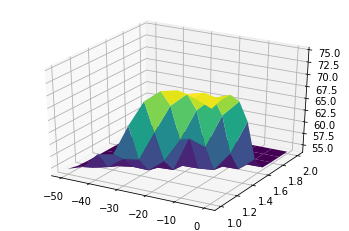

In [10]:
# example vis
def f(A, n):
    return (-A / 10) + n**2

def fn(Av, nv):
    Z = []
    for A in Av:
        Zn = []
        for n in nv:
            Zn.append((-A / 10) + n**2)
        Z.append(Zn)
    
    return np.array(Z)

A = np.linspace(0, -50, 10)
n = np.linspace(1, 2, 10)

Z = f_trilat(A, n)

A, n = np.meshgrid(A, n)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(A, n, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')

plt.show()